# Introduction 
This python notebook will explore a dataset from the <code>Datasets</code> library in order to analyze top contributing factors to customers cancelling subscriptions to service as well as analyze the behaviourioul data of customers in order to idenitfy a pattern and train a model which can identify customers that are likely to leave the company or stop using a product or service

In [127]:
# library importing
from datasets import load_dataset
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [119]:
# load dataset
dataset = load_dataset("scikit-learn/churn-prediction")

In [120]:
df = pd.DataFrame(dataset["train"])
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## EDA 
Explore dataset and gain valuable insights

In [121]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [122]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Most of the features are categorical data with some being binary data (example: PhoneService). 
This info gives us a good idea on the preprocessing steps that we will have to carry out later

In [124]:
(df.isnull().sum() / len(df)) * 100

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

No missing values, thats good !

In [125]:
df.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

binary data columns: gender, Partner, Dependants, PhoneService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PaperlessBilling

These need to be encoded using one hot encoding 

In [128]:
# will need to convert this column to float64 data type since it was in object type initially (not sure why it was in object since these are clearly values)

# Replace empty or whitespace strings with NaN
df["TotalCharges"] = df["TotalCharges"].replace(r"^\s*$", np.nan, regex=True)

df["TotalCharges"] = df["TotalCharges"].astype(float)

In [143]:
df["TotalCharges"].isnull().sum()
#hmmm 11 null rows. can drop ?

11

In [129]:
df_copy = df.copy(deep=True)

array([[<Axes: title={'center': 'TotalCharges'}>]], dtype=object)

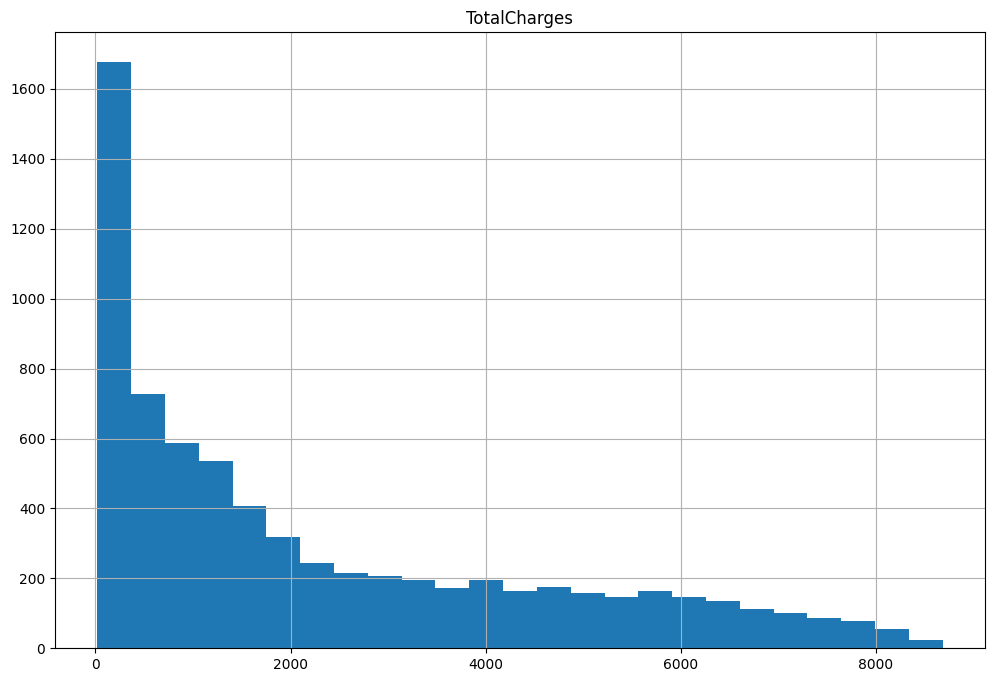

In [131]:
df_copy.hist(column="TotalCharges", bins=25, grid=True, figsize=(12, 8))

Dist skewed to the right. to fill up the NA vals we will do median imputation. However I might change this approach later on to just drop the NA value rows altogether

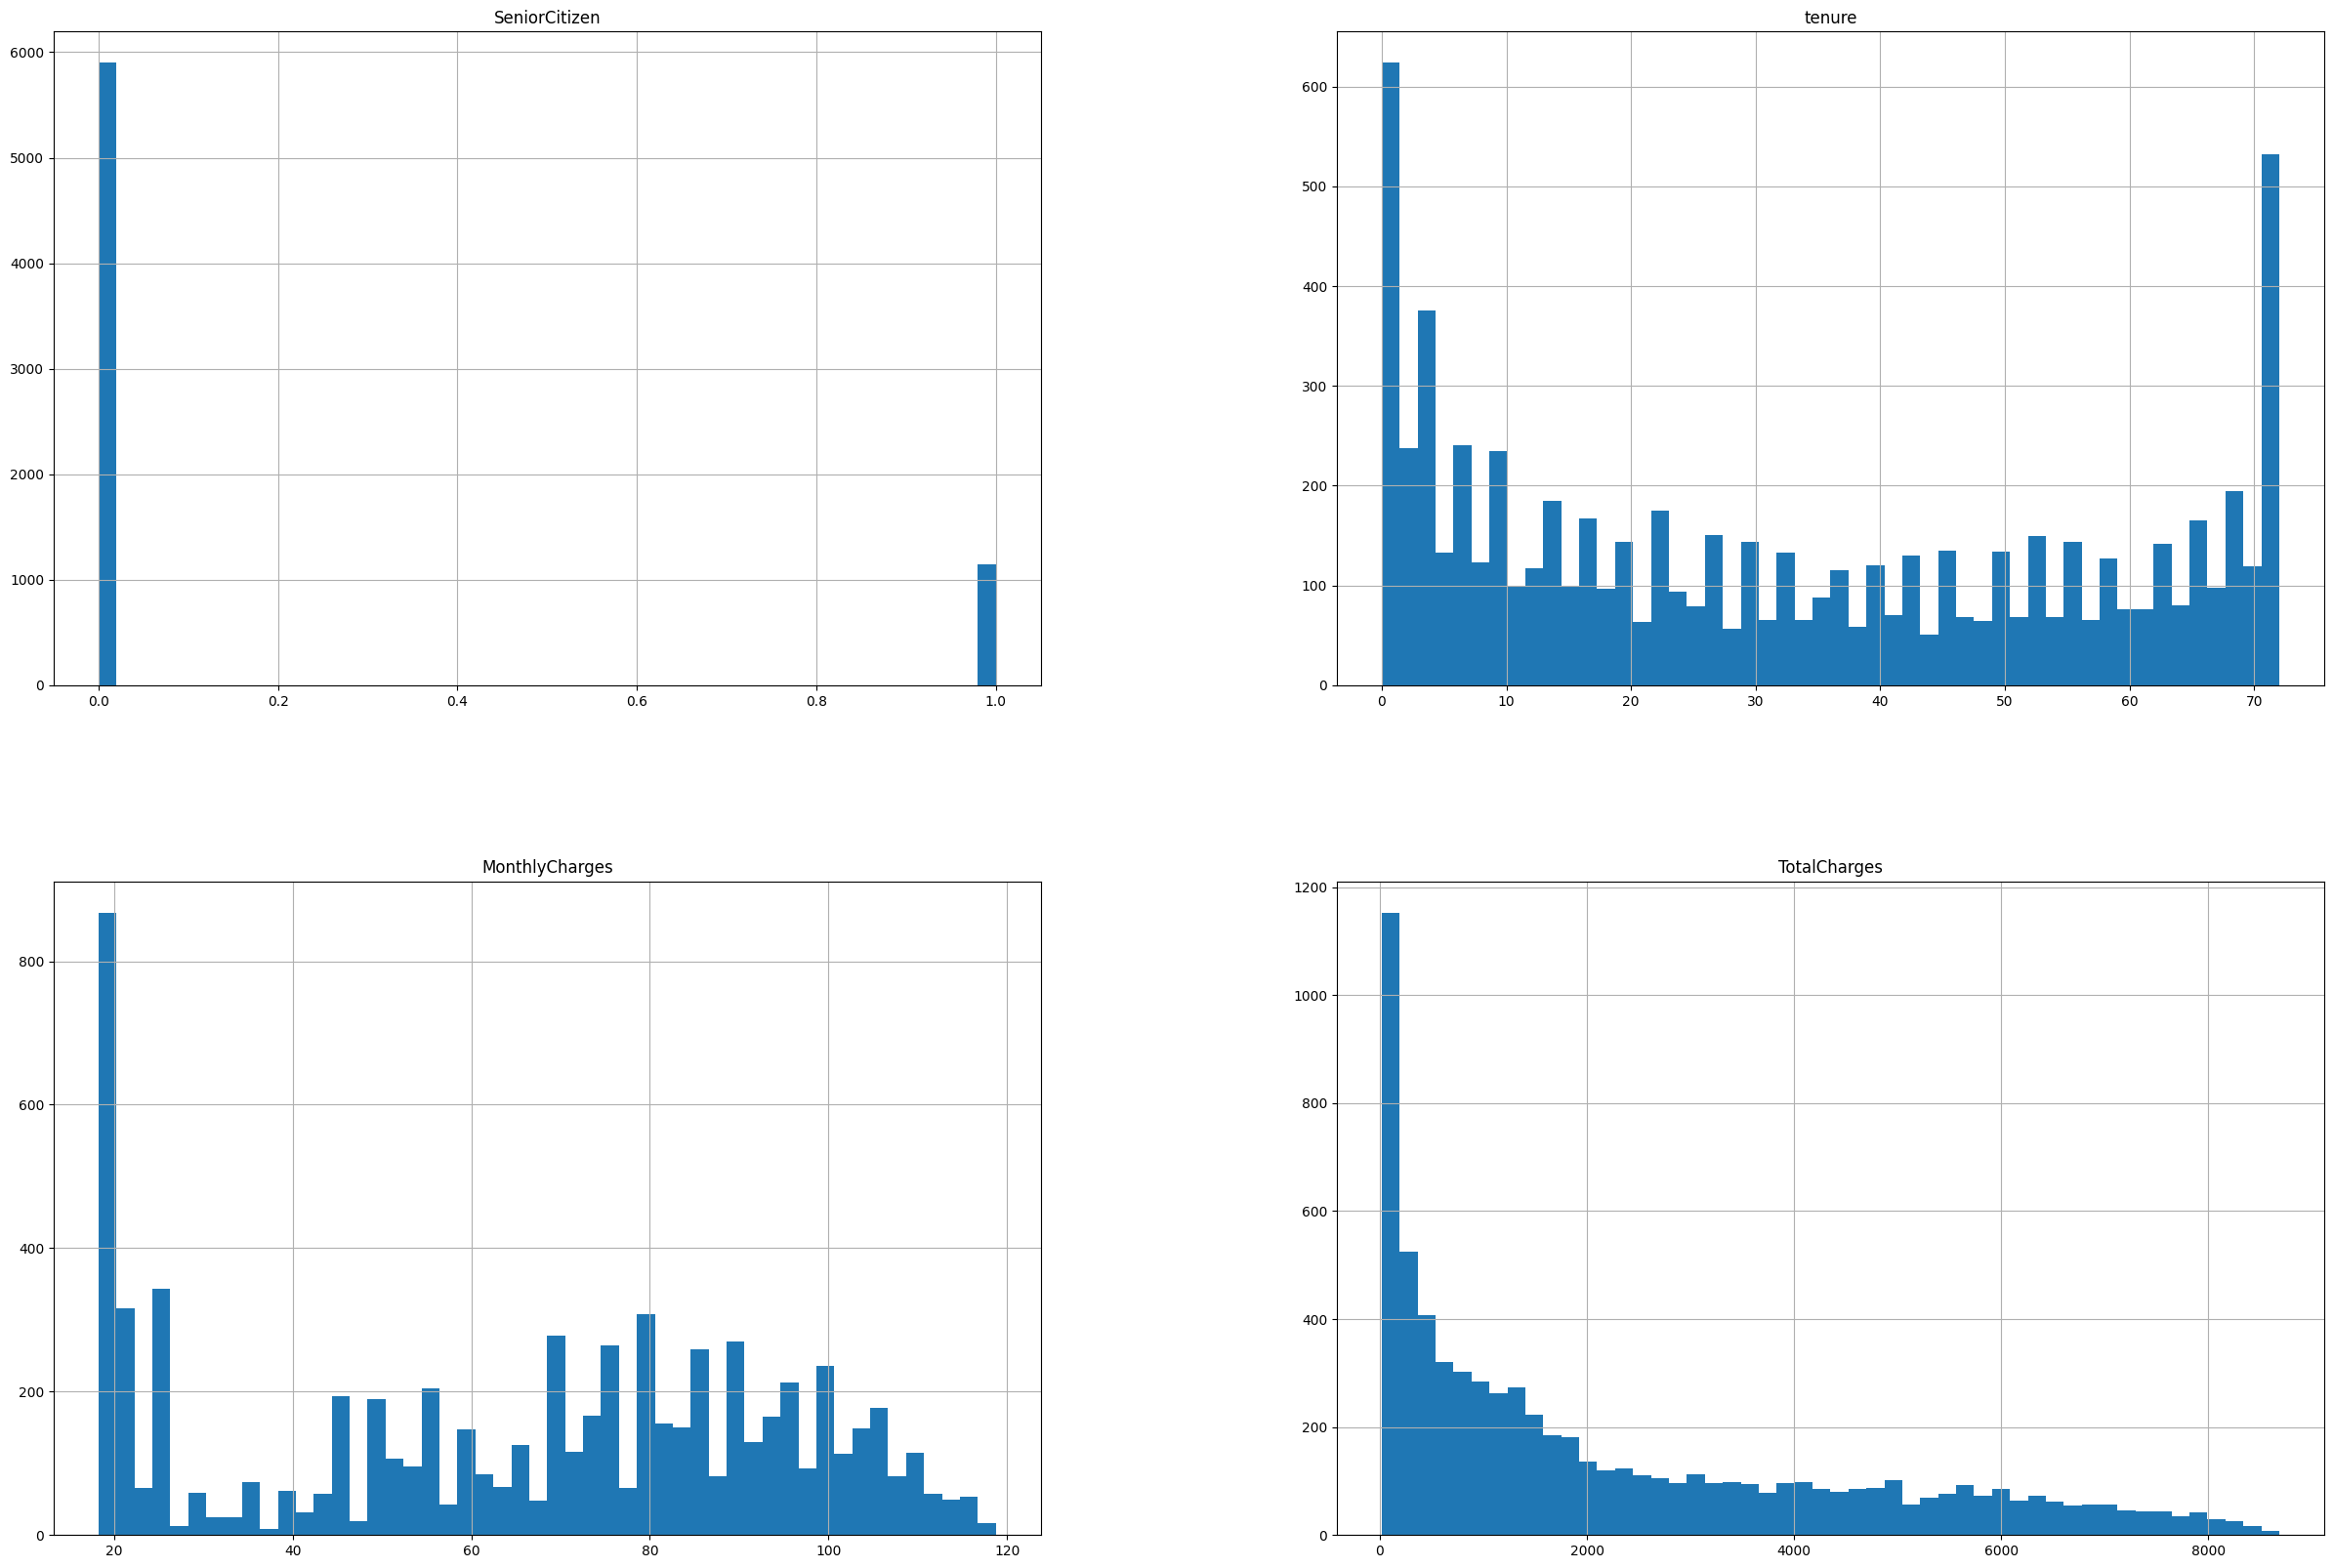

In [132]:
# charts for data distribution
df_copy.hist(bins=50, figsize=(30, 20))
plt.show()

'TotalCharges' has a distribution skewed to the right.  
MonthlyCharges skewed to the right  
'tenure' has a bimodal distributon with peaks on the extreme left annd right

<BarContainer object of 100 artists>

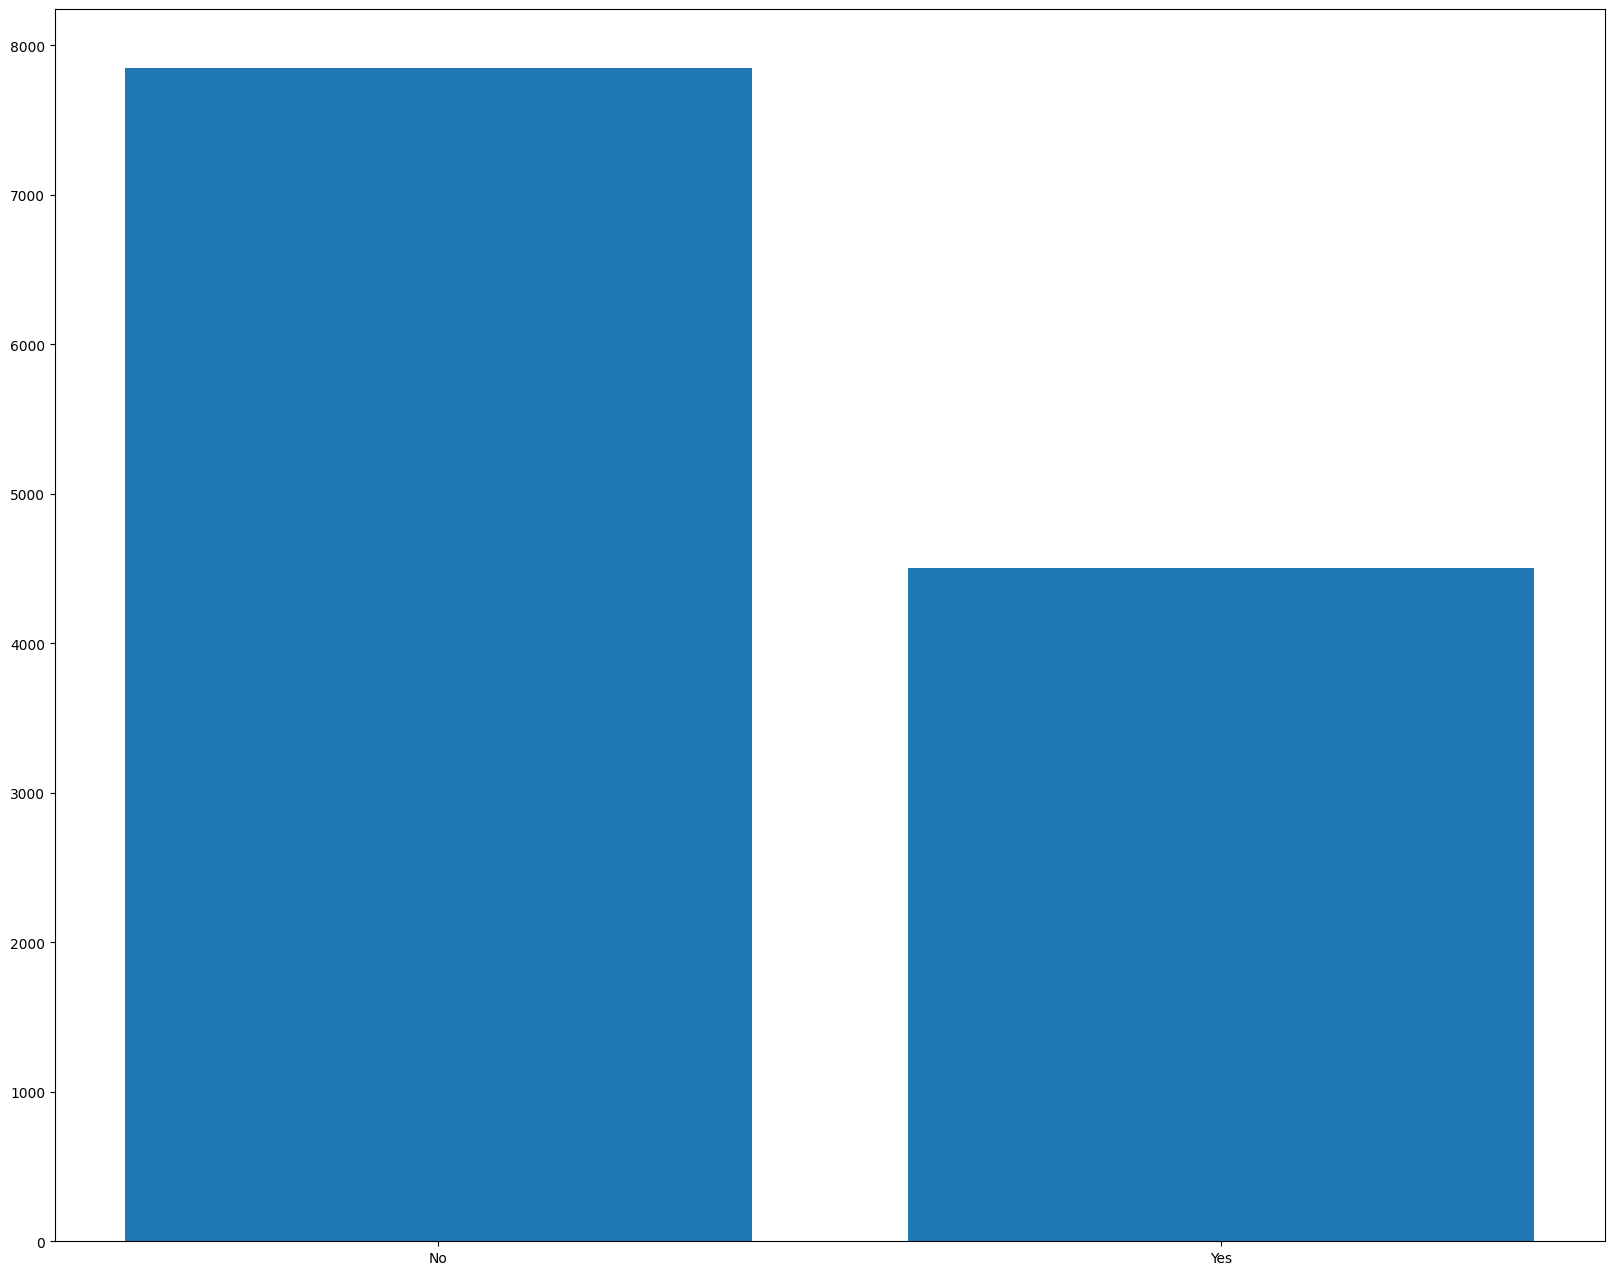

In [139]:
# how do charge features affect Churn

df_sam = df_copy.sample(n=100)
plt.figure(figsize=(20, 16))
plt.bar(df_sam["Churn"], df_sam["TotalCharges"])

In [142]:
# proportion of nos and yesses
(df_copy["Churn"].value_counts() / len(df_copy)) * 100

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

only 26.5 % of the records are for 'Yes'. we will need to carry out stratified sampling in order to get equal number of records so that the resulting model is unbiased

## Data Preprocessing 

### Encoding

#### Unique value count table 

In [ ]:
# unique val count
unique_counts = (
    pd.DataFrame(df.nunique(), columns=["Unique_Values"])
    .reset_index()
    .rename(columns={"index": "Variable"})
)

unique_counts

,Variable,Unique_Values
0,customerID,7043
1,gender,2
2,SeniorCitizen,2
3,Partner,2
4,Dependents,2
5,tenure,73
6,PhoneService,2
7,MultipleLines,3
8,InternetService,3
9,OnlineSecurity,3


#### Binary Encoding

In [ ]:
# binary encoding gender
df["gender"].value_counts()
df["gender"] = df["gender"].map({"Male": 1, "Female": 0})

#### One-Hot Encoding

In [ ]:
# Internet Service
enc_InternetService = pd.get_dummies(df["InternetService"], prefix="IS", dtype=int)
df = pd.concat([df, enc_InternetService], axis=1)
df = df.drop("InternetService", axis=1)

# Contract
enc_Contract = pd.get_dummies(df["Contract"], prefix="Contract", dtype=int)
df = pd.concat([df, enc_Contract], axis=1)
df = df.drop("Contract", axis=1)

# PaymentMethod
enc_PM = pd.get_dummies(df["PaymentMethod"], prefix="PM", dtype=int)
df = pd.concat([df, enc_PM], axis=1)
df = df.drop("PaymentMethod", axis=1)

# MultipleLines
enc_MultipleLines = pd.get_dummies(df["MultipleLines"], prefix="ML", dtype=int)
df = pd.concat([df, enc_MultipleLines], axis=1)
df = df.drop("MultipleLines", axis=1)

#### Binary Encoding 
For data that is just 'Yes' or 'No'

In [ ]:
# binary encoding all the binary data cols
bin_cols = [
    "Partner",
    "Dependents",
    "PhoneService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "PaperlessBilling",
]

for i in bin_cols:
    df[i] = df[i].map({"Yes": 1, "No": 0})

### Missing value filling

using median imputation

In [145]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

<code>TotalCharges</code> has missing values

In [146]:
# replace NA with median
# NOTE: This approach may be changed later depending on performance. though 11/7k+ records should not have a major effect on the model's ability
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())